In [1]:
import sklearn

In [2]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from __future__ import division
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import scipy
from scipy import stats
import astropy.io.ascii as ascii
from astropy.io import fits
import itertools
import operator

aegis_grism = fits.open('C:/Users/rohan naidu/Desktop/astro/aegis_3dhst_v4.1.5_catalogs/aegis_3dhst.v4.1.5.zfit.concat.fits', memmap=True)[1].data
cosmos_grism = fits.open('C:/Users/rohan naidu/Desktop/astro/cosmos_3dhst_v4.1.5_catalogs/cosmos_3dhst.v4.1.5.zfit.concat.fits', memmap=True)[1].data
goodsn_grism = fits.open('C:/Users/rohan naidu/Desktop/astro/goodsn_3dhst_v4.1.5_catalogs/goodsn_3dhst.v4.1.5.zfit.concat.fits', memmap=True)[1].data
goodss_grism = fits.open('C:/Users/rohan naidu/Desktop/astro/goodss_3dhst_v4.1.5_catalogs/goodss_3dhst.v4.1.5.zfit.concat.fits', memmap=True)[1].data
uds_grism = fits.open('C:/Users/rohan naidu/Desktop/astro/uds_3dhst_v4.1.5_catalogs/uds_3dhst.v4.1.5.zfit.concat.fits', memmap=True)[1].data

grism_id = np.concatenate((aegis_grism['grism_id'], \

cosmos_grism['grism_id'], \

goodsn_grism['grism_id'], \

goodss_grism['grism_id'], \

uds_grism['grism_id']))


z_max_grism = np.concatenate((aegis_grism['z_max_grism'], \

cosmos_grism['z_max_grism'], \

goodsn_grism['z_max_grism'], \

goodss_grism['z_max_grism'], \

uds_grism['z_max_grism']))

z_peak_phot = np.concatenate((aegis_grism['z_peak_phot'], \
cosmos_grism['z_peak_phot'], \
goodsn_grism['z_peak_phot'], \
goodss_grism['z_peak_phot'], \
uds_grism['z_peak_phot']))

delta_z = ((z_peak_phot - z_max_grism)/(z_peak_phot))

In [3]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

def wavelength_window(inp_id, wavelength_arr):
    return find_nearest(wavelength_arr, ((z_max_grism[grism_id==inp_id]) + 1)*5000 )

def create_stamp(obj_grism_id):
    twod = fits.open((obj_grism_id+".2D.fits"), memmap=True)
    zfit = fits.open((obj_grism_id+ ".new_zfit.fits"), memmap=True)
    science = twod[5].data
    contam = twod[8].data
    wavelength = twod[9].data
    centre_stamp = wavelength_window(obj_grism_id, wavelength)
    
    #have to think about lines on edge of grism
    stamp_side = int(np.shape(science)[0])
    edge_flag = 0
    left_window = centre_stamp-stamp_side/2
    right_window = centre_stamp + stamp_side/2
    
    if left_window<0:
        left_window = 0
        edge_flag = 1
    
    if right_window> int(np.shape(science)[1]) :
        right_window = int(np.shape(science)[1])
        edge_flag=1


    img_array = (science-(contam+ (zfit[2].data) + (zfit[1].data)))
    
    return (science[0::, left_window:right_window], contam[0::, left_window:right_window], img_array[0::, left_window:right_window])

creator = np.vectorize(create_stamp)

In [4]:
h = .02  # step size in the mesh
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "Linear Discriminant Analysis",
         "Quadratic Discriminant Analysis"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]


def prep_dataset(params, truth_arr):
    truth = np.array(truth_arr)
    dataset_arr = []
    for x in range(1, len(params)+1):
        for indx in itertools.combinations(params,x):
            inter = (np.array(indx)).T
            #print inter
            #print dataset_arr
            #print (inter, truth)
            dataset_arr.append(tuple((inter, truth)))
    return dataset_arr

def prep_dataset_labels(labels):
    dataset_labels_arr = []
    for x in range(1, len(labels)+1):
        for indx in itertools.combinations(labels,x):
            dataset_labels_arr.append(indx)
    return dataset_labels_arr

In [5]:
os.chdir("C:/Users/rohan naidu/Desktop/astro/stamp_mosaics/one/")
obj_list = (np.unique(np.array([x.split(".")[0] for x in glob.glob("*.new_zfit.fits")])))

frac_neg_pix = np.zeros(len(obj_list))
mean_pix = np.zeros(len(obj_list))
median_pix = np.zeros(len(obj_list))
rms_pix = np.zeros(len(obj_list))
frac_flagged_pix = np.zeros(len(obj_list))
max_img_pix = np.zeros(len(obj_list))
std_img_pix = np.zeros(len(obj_list))
max_contam_pix = np.zeros(len(obj_list))
mean_contam_pix = np.zeros(len(obj_list))
median_contam_pix = np.zeros(len(obj_list))
rms_contam_pix = np.zeros(len(obj_list))
std_contam_pix = np.zeros(len(obj_list))
max_science_pix= np.zeros(len(obj_list))
mean_science_pix = np.zeros(len(obj_list))
median_science_pix = np.zeros(len(obj_list))
rms_science_pix = np.zeros(len(obj_list))
std_science_pix = np.zeros(len(obj_list))
min_img_pix = np.zeros(len(obj_list))
range_img_pix = np.zeros(len(obj_list))
min_contam_pix = np.zeros(len(obj_list))
range_contam_pix = np.zeros(len(obj_list))
min_science_pix = np.zeros(len(obj_list))
range_science_pix = np.zeros(len(obj_list))


for ind in range(0, len(obj_list)):
    science = ((create_stamp(obj_list[ind])))[0]
    contam = ((create_stamp(obj_list[ind])))[1]
    img =((create_stamp(obj_list[ind])))[2]
    
    frac_neg_pix[ind] = np.count_nonzero(img<0)/(int(img.shape[0]) * int(img.shape[1]))
    mean_pix[ind] = np.mean(img)
    median_pix[ind] = np.median(img)
    rms_pix[ind] = (np.mean(np.square(img)))**0.5
    frac_flagged_pix[ind] = np.count_nonzero(img==0)/(int(img.shape[0]) * int(img.shape[1]))
    max_img_pix[ind] = np.max(img)
    std_img_pix[ind] = np.std(img)
    
    min_img_pix[ind] = np.min(img)
    range_img_pix[ind] = np.max(img) - np.min(img)
    
    
    
    max_contam_pix[ind] = np.max(contam)
    mean_contam_pix[ind] = np.mean(contam)
    median_contam_pix[ind] = np.median(contam) 
    rms_contam_pix[ind] = (np.mean(np.square(contam)))**0.5
    std_contam_pix[ind] = np.std(contam)

    
    min_contam_pix[ind] = np.min(contam)
    range_contam_pix[ind] = np.max(contam) - np.min(contam)
    
    
    max_science_pix[ind] = np.max(science)
    mean_science_pix[ind] = np.mean(science)
    median_science_pix[ind] = np.median(science) 
    rms_science_pix[ind] = (np.mean(np.square(science)))**0.5
    std_science_pix[ind] = np.std(science)
    
    min_science_pix[ind] = np.min(science)
    range_science_pix[ind] = np.max(science) - np.min(science)
    

    
del_z_pix = delta_z[np.array([True if x in obj_list else False for x in grism_id])]

In [6]:
os.chdir("C:/Users/rohan naidu/Desktop/astro/stamp_mosaics/zero/")
obj_list = (np.unique(np.array([x.split(".")[0] for x in glob.glob("*.new_zfit.fits")])))

frac_neg_zero = np.zeros(len(obj_list))
mean_zero = np.zeros(len(obj_list))
median_zero = np.zeros(len(obj_list))
rms_zero = np.zeros(len(obj_list))
frac_flagged_zero = np.zeros(len(obj_list))
max_img_zero = np.zeros(len(obj_list))
std_img_zero = np.zeros(len(obj_list))
max_contam_zero = np.zeros(len(obj_list))
mean_contam_zero = np.zeros(len(obj_list))
median_contam_zero = np.zeros(len(obj_list))
rms_contam_zero = np.zeros(len(obj_list))
std_contam_zero = np.zeros(len(obj_list))
max_science_zero= np.zeros(len(obj_list))
mean_science_zero = np.zeros(len(obj_list))
median_science_zero = np.zeros(len(obj_list))
rms_science_zero = np.zeros(len(obj_list))
std_science_zero = np.zeros(len(obj_list))
min_img_zero = np.zeros(len(obj_list))
range_img_zero = np.zeros(len(obj_list))
min_contam_zero = np.zeros(len(obj_list))
range_contam_zero = np.zeros(len(obj_list))
min_science_zero = np.zeros(len(obj_list))
range_science_zero = np.zeros(len(obj_list))

for ind in range(0, len(obj_list)):
    science = ((create_stamp(obj_list[ind])))[0]
    contam = ((create_stamp(obj_list[ind])))[1]
    img =((create_stamp(obj_list[ind])))[2]
    
    frac_neg_zero[ind] = np.count_nonzero(img<0)/(int(img.shape[0]) * int(img.shape[1]))
    mean_zero[ind] = np.mean(img)
    median_zero[ind] = np.median(img)
    rms_zero[ind] = (np.mean(np.square(img)))**0.5
    frac_flagged_zero[ind] = np.count_nonzero(img==0)/(int(img.shape[0]) * int(img.shape[1]))
    max_img_zero[ind] = np.max(img)
    std_img_zero[ind] = np.std(img)
    
    max_contam_zero[ind] = np.max(contam)
    mean_contam_zero[ind] = np.mean(contam)
    median_contam_zero[ind] = np.median(contam) 
    rms_contam_zero[ind] = (np.mean(np.square(contam)))**0.5
    std_contam_zero[ind] = np.std(contam)
    
    max_science_zero[ind] = np.max(science)
    mean_science_zero[ind] = np.mean(science)
    median_science_zero[ind] = np.median(science) 
    rms_science_zero[ind] = (np.mean(np.square(science)))**0.5
    std_science_zero[ind] = np.std(science)
    
    min_science_zero[ind] = np.min(science)
    range_science_zero[ind] = np.max(science) - np.min(science)
    min_contam_zero[ind] = np.min(contam)
    range_contam_zero[ind] = np.max(contam) - np.min(contam)
    min_img_zero[ind] = np.min(img)
    range_img_zero[ind] = np.max(img) - np.min(img)


del_z_zero = delta_z[np.array([True if x in obj_list else False for x in grism_id])]

In [7]:
len_good = len(del_z_pix)
len_bad = len(del_z_zero)
known_flags = np.concatenate(([0]*len_bad, [1]*len_good))
frac_neg = np.concatenate((frac_neg_zero , frac_neg_pix))
mean = np.concatenate((mean_zero , mean_pix))
median = np.concatenate((median_zero , median_pix))
rms = np.concatenate((rms_zero , rms_pix))
frac_flagged = np.concatenate((frac_flagged_zero , frac_flagged_pix))
max_img = np.concatenate((max_img_zero , max_img_pix))
std_img = np.concatenate((std_img_zero , std_img_pix))
max_contam = np.concatenate((max_contam_zero , max_contam_pix))
mean_contam = np.concatenate((mean_contam_zero , mean_contam_pix))
median_contam = np.concatenate((median_contam_zero , median_contam_pix))
rms_contam = np.concatenate((rms_contam_zero , rms_contam_pix))
std_contam = np.concatenate((std_contam_zero , std_contam_pix))
max_science= np.concatenate((max_science_zero , max_science_pix))
mean_science = np.concatenate((mean_science_zero , mean_science_pix))
median_science = np.concatenate((median_science_zero , median_science_pix))
rms_science = np.concatenate((rms_science_zero , rms_science_pix))
std_science = np.concatenate((std_science_zero , std_science_pix))
del_z = np.concatenate((del_z_zero , del_z_pix))

min_img = np.concatenate((min_img_zero, min_img_pix))
range_img = np.concatenate((range_img_zero, range_img_pix ))
min_contam = np.concatenate((min_contam_zero, min_contam_pix))
range_contam = np.concatenate((range_contam_zero,range_contam_pix ))
min_science = np.concatenate((min_science_zero,min_science_pix ))
range_science = np.concatenate((range_science_zero,range_science_pix ))

In [ ]:
params_arr = [frac_neg, rms, max_img, max_contam, max_img-max_contam, rms_contam]

In [8]:
params_arr = [frac_neg,mean,median,rms,frac_flagged,max_img,std_img,max_contam,mean_contam,median_contam,\
                          rms_contam,std_contam,max_science, mean_science,median_science,rms_science,std_science,\
                         del_z, min_img, range_img, min_contam, range_contam, min_science, range_science]

param_names_arr = ["frac_neg","mean","median","rms","frac_flagged","max_img","std_img","max_contam",\
 "mean_contam","median_contam","rms_contam","std_contam","max_science","mean_science","median_science","rms_science","std_science","del_z",\
                  "min_img","range_img","min_contam","range_contam","min_science","range_science"]

#labels = prep_dataset_labels(param_names_arr)

In [10]:
import pickle
with open("params_962_24.pickle",'wb') as f:
    pickle.dump(params_arr,f)

In [21]:
os.getcwd()

'C:\\Users\\rohan naidu\\Desktop\\astro'

In [22]:
import pickle
with open("truth_962_24.pickle",'wb') as f:
    pickle.dump(known_flags,f)

In [11]:
in_result = pickle.load(open( "params_962_24.pickle", "rb" ))

In [30]:
check_result = pickle.load(open( "euler_joblib.pickle", "rb" ))

In [31]:
check_result

[[0.80215842472861909,
  0.77297037016259473,
  0.76216655914280107,
  0.70817321627256835,
  0.6897375482688658,
  0.76217357156881993,
  0.71572559909492961,
  0.78053210288631458,
  0.77082456780080966,
  0.75785391714117423,
  0.76544369956896952,
  0.76976569147195495,
  0.72000084149112231,
  0.75568474002599273,
  0.77405963367086472,
  0.72758361149289874,
  0.69840958177891221,
  0.7102722691275607,
  0.68327209147943491,
  0.72760698624629505,
  0.72865651267379128,
  0.77513253485175726,
  0.6757033463296962,
  0.70163296027226907],
 [0.78810084803605318,
  0.78269894252615635,
  0.80542154030274982,
  0.7989093340065262,
  0.78055314016437127,
  0.81082578328798638,
  0.82594691126008613,
  0.83244041775359268,
  0.81946976709395714,
  0.8421596402157957,
  0.82809972604789017,
  0.78271296737819418,
  0.80433227679447983,
  0.81620431404448679,
  0.78704430918253809,
  0.78164240367264126,
  0.79674716931736367,
  0.79243920226641607,
  0.8043392892204988,
  0.795655568333

In [ ]:
itertools.combinations(params_arr[0:5], )

In [36]:
#param_names_arr = ['mean', 'max_img', 'rms_contam', 'rms_science']

params_arr = [frac_neg,mean,median, max_img, max_contam,mean_contam,\
                          rms_contam, max_science, mean_science,median_science,\
                         del_z]

datasets= [(prep_dataset(params_arr, known_flags))[-1]]
#labels = [(prep_dataset_labels(param_names_arr))[-1]]


#maxer_score = []
max_score = 0
score_arr = []
index = -1
result_arr = []    
for ds in datasets:
    index = index+1
    #print param_names_arr[index]
    inter_res_arr = []
    X, y = ds
    X = StandardScaler().fit_transform(X)
    for x in range(0,1000):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
        #for name, clf in zip(names, classifiers):
        #for clf in classifiers:
        clf = AdaBoostClassifier()
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        inter_res_arr.append(score)
        #result_arr.append(tuple( (score, name, labels[index]) ))
        #print score
        score_arr.append(score)
        #print "Name:%s, Score: %s, Index: %d"%(name, score, index)
        #if score>=max_score:
         #   print score
        #   max_score = score
        #print "Score: %s"%(score)

    #print (np.sort(inter_res_arr))[-5:-1]

        #result_arr.sort(key=lambda x: x[0])
        #ans = result_arr[::-1]
        #print ans[0:10]

        #maxer_score.append(np.max(score_arr))
        #if np.max(score_arr)>= np.max(maxer_score):
        #    print np.max(score_arr)

print np.sort(score_arr)[-10:-1]
print np.min(score_arr)

[ 0.91891892  0.91891892  0.92432432  0.92432432  0.92432432  0.92432432
  0.92432432  0.92972973  0.93513514]
0.789189189189


In [37]:
X, y = (prep_dataset(params_arr, known_flags))[-1]

In [38]:
X = StandardScaler().fit_transform(X)

In [71]:
results_mean = []
results_std = []
for tv in range(2, 281):
    clf= AdaBoostClassifier()
    scores = sklearn.cross_validation.cross_val_score(clf, X, y, cv=tv)
    results_mean.append(scores.mean())
    results_std.append(scores.std()*2)
    #print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [74]:
%matplotlib inline

C:\Anaconda\lib\site-packages\matplotlib\collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


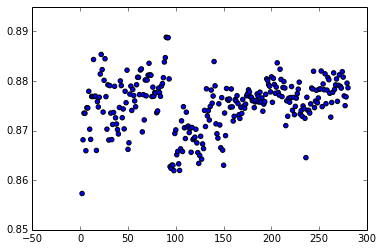

In [79]:
plt.scatter(range(2,281), results_mean)

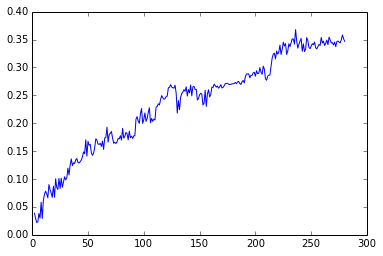

In [76]:
plt.plot(range(2,281), results_std)

In [78]:
np.mean(results_mean)

0.87523767341243697